In [1]:
import itertools
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import time
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from dataset import Dataset

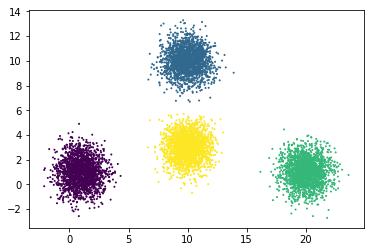

In [2]:
sess = tf.InteractiveSession()
normal = tfd.MultivariateNormalDiag(loc=[0.0, 0.0], scale_diag=[1.0, 1.0])
s1 = [1,1] + sess.run(normal.sample(2000))
s2 = [10, 10] + sess.run(normal.sample(2000))
s3 = [20, 1] + sess.run(normal.sample(2000))
s4 = [10, 3] + sess.run(normal.sample(2000))
samples = np.concatenate((s1,s2,s3,s4))
gnd = np.concatenate((np.zeros(2000), np.zeros(2000)+1,np.zeros(2000)+2,np.zeros(2000)+3))
plt.scatter(samples[:,0], samples[:,1], s=1, c=gnd)

In [3]:
def inference_network(x, latent_dim, hidden_size):
    """
    Construct an inference network parametrizing the logits of Gumbel-Max.
    """
    with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
        net = slim.fully_connected(x, hidden_size)
        net = slim.fully_connected(net, hidden_size)
        logits = slim.fully_connected(net, latent_dim)
    return logits


def generative_network(z, x_dim, hidden_size):
    """
    Build a generative network parametrizing the likelihood of the data
    """
    with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
        net = slim.fully_connected(z, hidden_size)
        net = slim.fully_connected(net, hidden_size)
        gaussian_params = slim.fully_connected(net, x_dim * 2, activation_fn=None)
        mu = gaussian_params[:, :x_dim]
        sigma = tf.nn.softplus(gaussian_params[:, x_dim:])
    
    return mu, sigma

In [4]:
t1 = 4.0
t2 = 4.0
latent_dim = 8 #Latent dimensionality of model
x_dim = 2 # dimension of data point
batch_size = 64 #Minibatch size
n_samples = 10 #Number of samples to save
print_every = 10 #Print every n iterations
hidden_size = 1000 #Hidden size for neural networks
n_iterations = 1000 #number of iterations

In [5]:
tf.reset_default_graph()
# Input placeholders
with tf.name_scope('data'):
    x = tf.placeholder(tf.float32, [None, x_dim])

with tf.variable_scope('variational'):
    logits = inference_network(x=x,latent_dim=latent_dim,hidden_size=hidden_size)
    # The variational distribution
    q_z = tfd.RelaxedOneHotCategorical(t1, logits=logits, dtype=tf.float32)
    assert q_z.reparameterization_type == tfd.FULLY_REPARAMETERIZED

with tf.variable_scope('model'):
    # The likelihood
    q_z_sample = q_z.sample()
    p_x_given_z_mu, p_x_given_z_sigma = generative_network(z=q_z_sample, x_dim=x_dim,
                                            hidden_size=hidden_size)
    p_x_given_z = tfd.MultivariateNormalDiag(loc=p_x_given_z_mu, scale_diag=p_x_given_z_sigma)
    posterior_predictive_samples = p_x_given_z.sample()
    
#     Take samples from the prior
with tf.variable_scope('model', reuse=True):
    p_z = tfd.RelaxedOneHotCategorical(t2, logits=[1.0 / latent_dim] * latent_dim, dtype=tf.float32)

# Build the evidence lower bound (ELBO) or the negative loss

kl = q_z.log_prob(q_z_sample) - p_z.log_prob(q_z_sample)

expected_log_likelihood = tf.reduce_sum(p_x_given_z.log_prob(x))

elbo = tf.reduce_sum(expected_log_likelihood - kl)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

train_op = optimizer.minimize(-elbo)




In [6]:
# Run training
perm = np.random.permutation(np.arange(samples.shape[0]))
print(perm)
samples = samples[perm]
gnd = gnd[perm]
data = Dataset(samples, ratio=0.8)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
t0 = time.time()
t1 = time.time()
elbos = []
vals = []
for i in range(n_iterations):
    # Re-binarize the data at every batch; this improves results
    x_trn = data.next_batch(batch_size=batch_size, roll_over=True)
    sess.run(train_op, {x: x_trn})

    # Print progress and save samples every so often
    if i % print_every == 0:
        np_elbo = sess.run(elbo, {x: x_trn})
        elbos += [-np_elbo]
        val_loss = sess.run(elbo, {x: data.validation_batch()})
        vals += [-val_loss]
        print('Iteration: {0:d} ELBO: {1:.3f} s/iter: {2:.3e}\r'.format(i,np_elbo / batch_size,(time.time() - t0) / print_every),end='')
    t0 = time.time()
    
print('total run-time:',time.time() - t1)



[1266 2207 2947 ... 1174 5217 6302]


/srv/home/009984221/miniconda3/envs/deep_prob/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


total run-time: 23.0374276638031iter: 5.603e-03


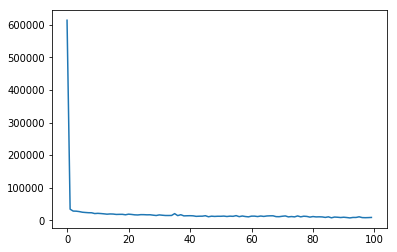

In [7]:
plt.plot(elbos)

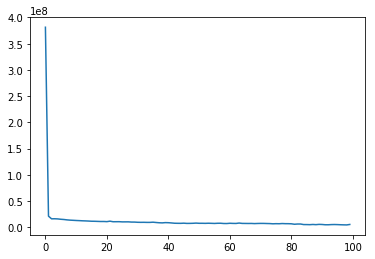

In [8]:
plt.plot(vals)

In [9]:
post_logits = sess.run(logits, {x:data.x_val})
print(post_logits)

[[-0.         -0.         -0.         ...  1.5304713  -0.
  25.555283  ]
 [-0.         21.821827   -0.         ... -0.         -0.
  -0.        ]
 [-0.         20.518528   -0.         ... -0.         -0.
  -0.        ]
 ...
 [-0.         -0.         -0.         ... -0.         23.636673
  -0.        ]
 [-0.         21.255072   -0.         ... -0.         -0.
   4.858943  ]
 [-0.         -0.         -0.         ... -0.          0.02705719
   0.32931045]]


[7 1 1 ... 6 1 7]


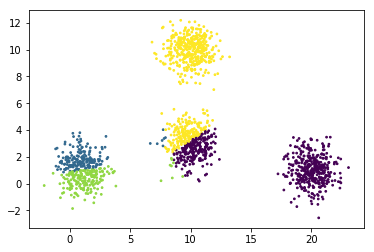

In [10]:
cat = np.argmax(post_logits, axis=1)
print(cat)
plt.scatter(data.x_val[:,0], data.x_val[:,1], c=cat, s=3)